Sample notebook for the plotting functionality

In [1]:
#For reference, which IDs correspond to which models:
# 20200124_110157 - ResNet-18-2 Abhi's version
# 20200128_234337 - ResNet-18-2 without batch norm layers
# 20200117_162156 - ResNet-152
# 20200110_170718 - ResNet-18
# 20200117_174658 - ResNet-18 validation
# 20200114_142948 - ResNet-18 (energy only)
# 20200117_172411 - ResNet-18 (energy only) validation
# 20200127_103916 - ResNet-18 barrel-only hits
# 20200128_092620 - ResNet-18 barrel-only hits validation
# 20200127_234613 - ResNet-18 first attempt at pixel by pixel ResNet
# 20200128_164239 - ResNet-18 barrel-only hits(batch size 50, 20 epochs, 5 degrees, 1 m radius, 3.5 m up and down)
# 20200130_163811 - ResNet-18 current barrel only hits
# 20200131_001030 - ResNet-18 Nick's full dataset
# 20200130_115926 - ResNet-18 Nick's dataset with barrel only hits
# 20200306_113956 - ResNet-18 current best model
# 20200308_195054 - ResNet-18 current best model (test)

In [2]:
## Imports
import sys
import os
import time
import math
import random
import pdb

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [3]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

Generic function to plot the training and validation log for each run

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [5]:
def plot_log(run_ids, model_ids, model_cls, keys, dumps_path, lgd_loc=(0.8,0.5), val=False, log=False, show=False, save_path=None, mov_av=False):
    """Plot the logs for any model from saved .csv files
    
    Args:
    run_ids    -- List of run ids e.g. ["20191202_171757", ...] for each model to be plotted
    model_ids  -- Names of the models for which the log is being plotted
    model_cls  -- Two colors for each model for one axis on each size of the plot
    keys       -- Two keys for columns in the dataframe to plot (To generalize to the VAE)
    dumps_path -- Absolute path to the global dump folder
    log        -- Boolean to determine whether to use (log scaling) or not
    lgd_loc    -- Tuple to determine the location of the legend
    show       -- Boolean to determine whether to call plt.show()
    save_path  -- Absolute path of the location at which to save the plot
    """
    
    # Defensive assertions to prevent Nonetype error
    assert run_ids is not None
    assert model_ids is not None
    assert model_cls is not None
    assert dumps_path is not None
    
    # Defensive assertion to prevent breaking function usage
    assert len(run_ids) == len(model_ids)
    assert len(model_ids) == len(model_cls)
    assert len(keys) == 2
    
    # Extract the values stored in the .csv files
    train_epochs = []
    val_epochs = []
    
    train_0 = []
    train_1 = []
    
    val_0 = []
    val_1 = []
    
    dumps_path = dumps_path + "/" if not dumps_path.endswith("/") else dumps_path
    dump_dirs = [dumps_path + run_id + "/" for run_id in run_ids]
    
    # Iterate over the logs for all the models
    i = 0
    for dump_dir in dump_dirs:
        
        train_log_path = dump_dir + "log_train.csv"
        val_log_path = dump_dir + "log_val.csv"
        
        if os.path.exists(train_log_path) and os.path.exists(val_log_path):
            train_log_df = pd.read_csv(train_log_path, usecols=["epoch",keys[0],keys[1]])
            if val:
                val_log_df = pd.read_csv(val_log_path, usecols=["epoch",keys[0],keys[1]])
        
        
        train_epochs.append(train_log_df["epoch"].values)
        train_0.append(train_log_df[keys[0]].values)
        train_1.append(train_log_df[keys[1]].values)
        
        # For moving average
        if mov_av:
            train_epochs[i]    = moving_average(train_epochs[i],400)
            train_0[i] = moving_average(train_0[i],400)
            train_1[i]     = moving_average(train_1[i],400)        
        
        if val:
            val_epochs.append(val_log_df["epoch"].values)
            val_0.append(val_log_df[keys[0]].values)
            val_1.append(val_log_df[keys[1]].values)
            
            # For moving average
            if mov_av:
                val_epochs[i]    = moving_average(val_epochs[i],40)
                val_0[i] = moving_average(val_0[i],40)
                val_1[i] = moving_average(val_1[i],40)
        
        i = i + 1
     
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    for i, model_ids in enumerate(model_ids):
        if val:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], alpha=0.5, linewidth=2.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], alpha=0.5, linewidth=2.0)
            
            ax1.plot(val_epochs[i], val_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=1.0, linewidth=2.5)
            ax2.plot(val_epochs[i], val_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=1.0, linewidth=2.5)
        else:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=0.5, linewidth=2.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=0.5, linewidth=2.0)
    
    if log:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel(keys[0], fontsize=30, color=model_colors[0][0])
    ax1.tick_params(axis="y", labelsize=30, color=model_colors[0][0])
    
    ax2.set_ylabel(keys[1], fontsize=30, color=model_colors[0][1])
    ax2.tick_params(axis="y", labelsize=30, color=model_colors[0][1])
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                     fancybox=True, shadow=True, framealpha=1.0)
    
    ax1.grid(True, which="both", axis="both")
    ax2.grid(True, which="both", axis="both")
    
    plt.margins(0.2)
    
    ax1.set_ylim([0.3,1.2])
    ax2.set_ylim([0,1])
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
    if show:
        try:
            plt.show()
        except:
            print("plot_log() : Unable to render the plot due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_log() : Saving plot to ./{0}".format("vae_training_log.pdf"))
                plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
            plt.clf()
            plt.close()
    else:
        plt.clf()
        plt.close()

In [6]:
def disp_learn_hist_smoothed(location, losslim=None, window_train=400,window_val=40,show=True):
    train_log=location+'/log_train.csv'
    val_log=location+'/log_val.csv'
    
    train_log_csv = pd.read_csv(train_log)
    val_log_csv  = pd.read_csv(val_log)

    epoch_train    = moving_average(np.array(train_log_csv.epoch),window_train)
    accuracy_train = moving_average(np.array(train_log_csv.accuracy),window_train)
    loss_train     = moving_average(np.array(train_log_csv.loss),window_train)
    
    epoch_val    = moving_average(np.array(val_log_csv.epoch),window_val)
    accuracy_val = moving_average(np.array(val_log_csv.accuracy),window_val)
    loss_val     = moving_average(np.array(val_log_csv.loss),window_val)

    epoch_val_uns    = np.array(val_log_csv.epoch)
    accuracy_val_uns = np.array(val_log_csv.accuracy)
    loss_val_uns     = np.array(val_log_csv.loss)
    #saved_best=np.array(val_log_csv.saved_best)
    #stored_indices=np.where(saved_best>1.0e-3)
    #epoch_val_st=epoch_val_uns[stored_indices]
    #accuracy_val_st=accuracy_val_uns[stored_indices]
    #loss_val_st=loss_val_uns[stored_indices]

    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    line11 = ax1.plot(epoch_train, loss_train, linewidth=2, label='Average training loss', color='b', alpha=0.3)
    line12 = ax1.plot(epoch_val, loss_val, label='Average validation loss', color='blue')
    #line13 = ax1.scatter(epoch_val_st, loss_val_st, label='BEST validation loss',
                         #facecolors='none', edgecolors='blue',marker='o')
    
    ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)
    if losslim is not None:
        ax1.set_ylim(0.,losslim)
    #else:
    #    ax1.set_ylim(0.,1)
    
    ax2 = ax1.twinx()
    line21 = ax2.plot(epoch_train, accuracy_train, linewidth=2, label='Average training accuracy', color='r', alpha=0.3)
    line22 = ax2.plot(epoch_val, accuracy_val, label='Average validation accuracy', color='red')
    #line23 = ax2.scatter(epoch_val_st, accuracy_val_st, label='BEST accuracy',
                         #facecolors='none', edgecolors='red',marker='o')
    
    
    ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,1.0)
    
    # added these four lines
    #lines  = line11+ line12+ [line13]+ line21+ line22+ [line23]
    lines  = line11+ line12+ line21+ line22
    #lines_sctr=[line13,line23]
    #lines=lines_plt+lines_sctr

    labels = [l.get_label() for l in lines]
    
    leg    = ax2.legend(lines, labels, fontsize=16, loc=5, numpoints=1)
    leg_frame = leg.get_frame()
    leg_frame.set_facecolor('white')

    if show:
        plt.grid()
        plt.show()
        return

    return fig

In [7]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    """Plot the signal efficiency vs. background rejection from softmax output
    
    softmaxes          -- 2D np array with shape (num_examples, num_classes)
    labels             -- 1D np array with true ordinal labels e.g. [0,1,2,0,1,...]
    energies           -- 1D np array with true energies for each event
    softmax_index_dict -- Dictionary mapping str class ids e.g. "gamma" to axis=1 idx
                          in the softmax array
    label_0            -- str class id for the signal class e.g. "e"
    label_1            -- str class id for the background class e.g. "gamma"
    min_energy         -- Minimum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    max_energy         -- Maximum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    show               -- Boolean to determine whether to call plt.show()
    save_path          -- Absolute path of the location at which to save the plot        
    """
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [8]:
# Function to plot a confusion matrix
def plot_confusion_matrix(labels, predictions, class_names):
    
    """
    plot_confusion_matrix(labels, predictions, class_names)
    
    Purpose : Plot the confusion matrix for a given energy interval
    
    Args: labels              ... 1D array of true label value, the length = sample size
          predictions         ... 1D array of predictions, the length = sample size
          class_names         ... 1D array of string label for classification targets, the length = number of categories
       
 
    """

    fig, ax = plt.subplots(figsize=(12,8),facecolor='w')
    num_labels = len(class_names)
    max_value = np.max([np.max(np.unique(labels)),np.max(np.unique(labels))])
    assert max_value < num_labels
    mat,_,_,im = ax.hist2d(predictions, labels,
                           bins=(num_labels,num_labels),
                           range=((-0.5,num_labels-0.5),(-0.5,num_labels-0.5)),cmap=plt.cm.Blues)

    # Normalize the confusion matrix
    mat = mat.astype("float") / mat.sum(axis=0)

    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20) 
        
    ax.set_xticks(np.arange(num_labels))
    ax.set_yticks(np.arange(num_labels))
    ax.set_xticklabels(class_names,fontsize=20)
    ax.set_yticklabels(class_names,fontsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlabel('Prediction',fontsize=20)
    ax.set_ylabel('True Label',fontsize=20)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i,j, r"${0:0.3f}$".format(mat[i,j]),
                    ha="center", va="center", fontsize=20,
                    color="white" if mat[i,j] > (0.5*mat.max()) else "black")
    plt.show()

Plot the training and validation log from the saved .csv files

One plot for each training run

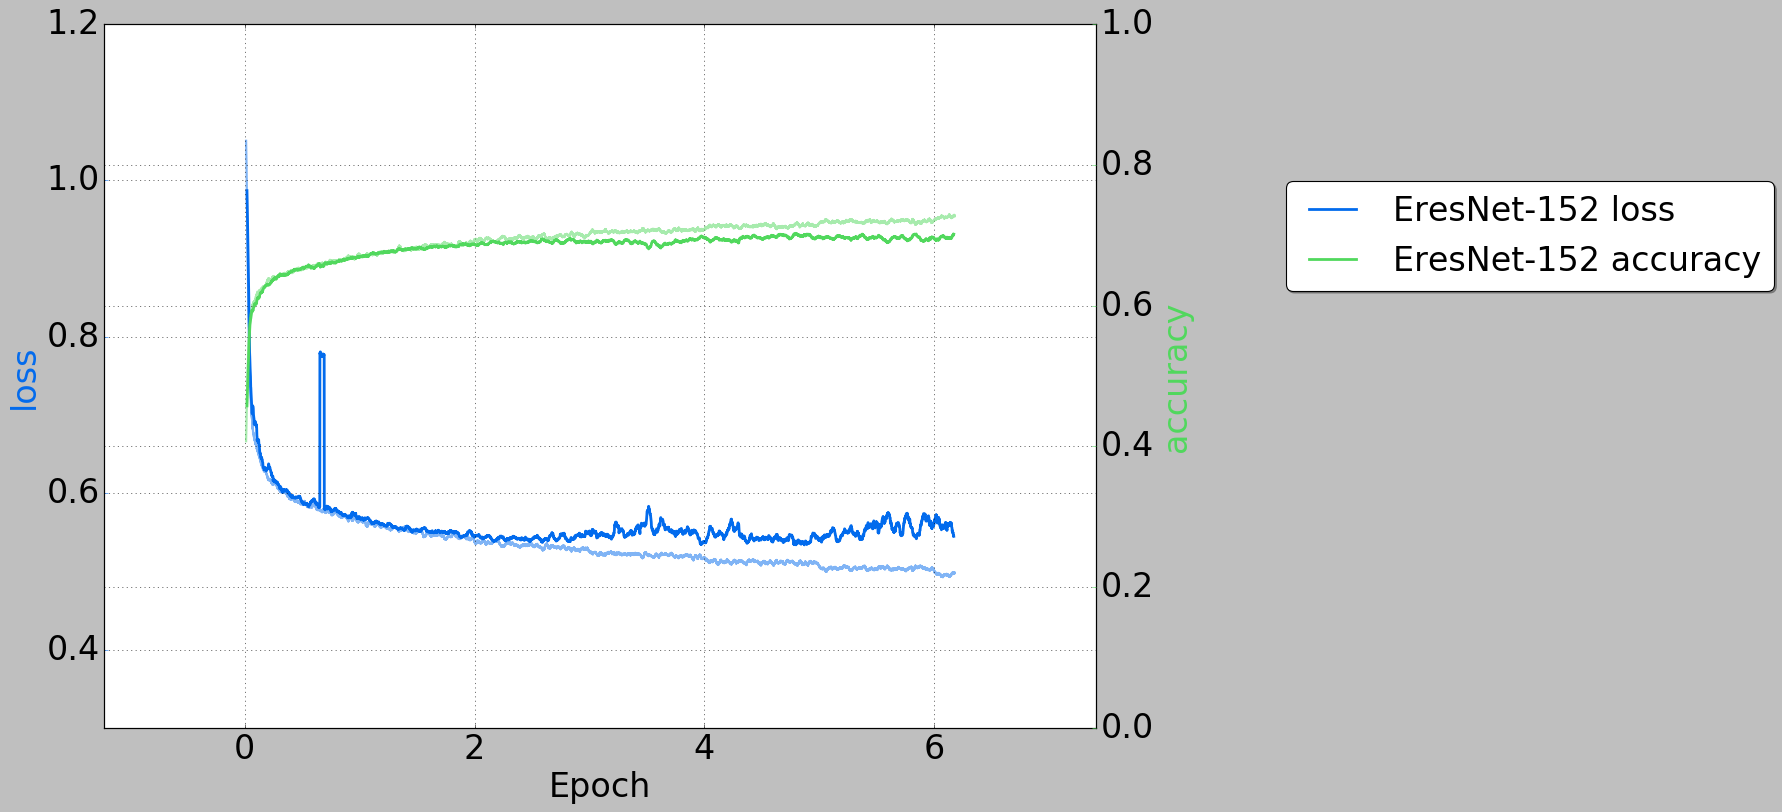

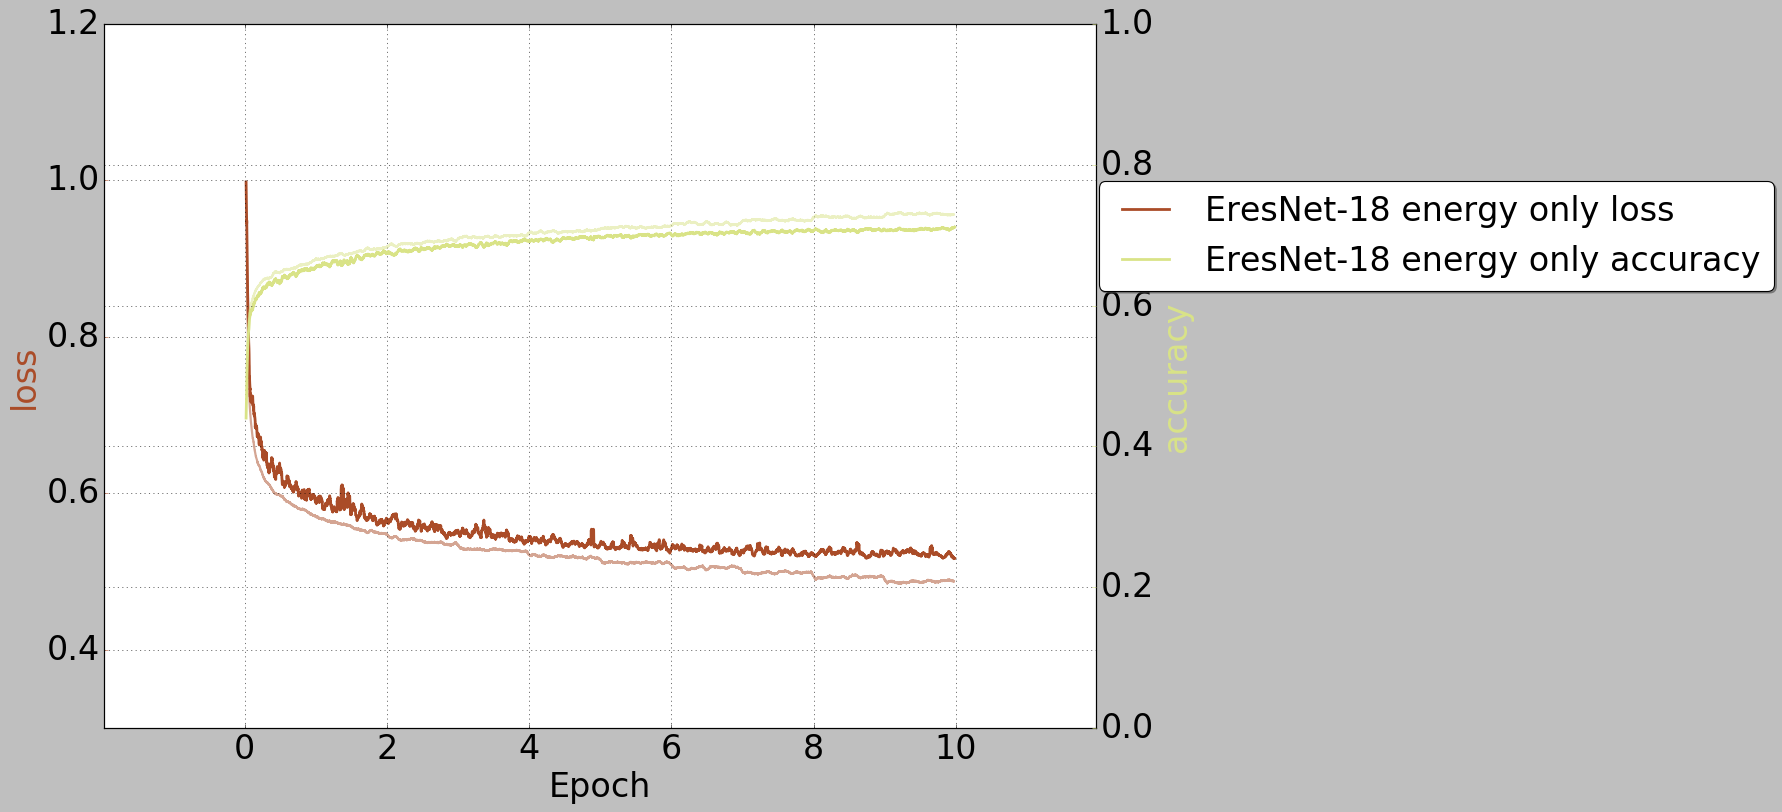

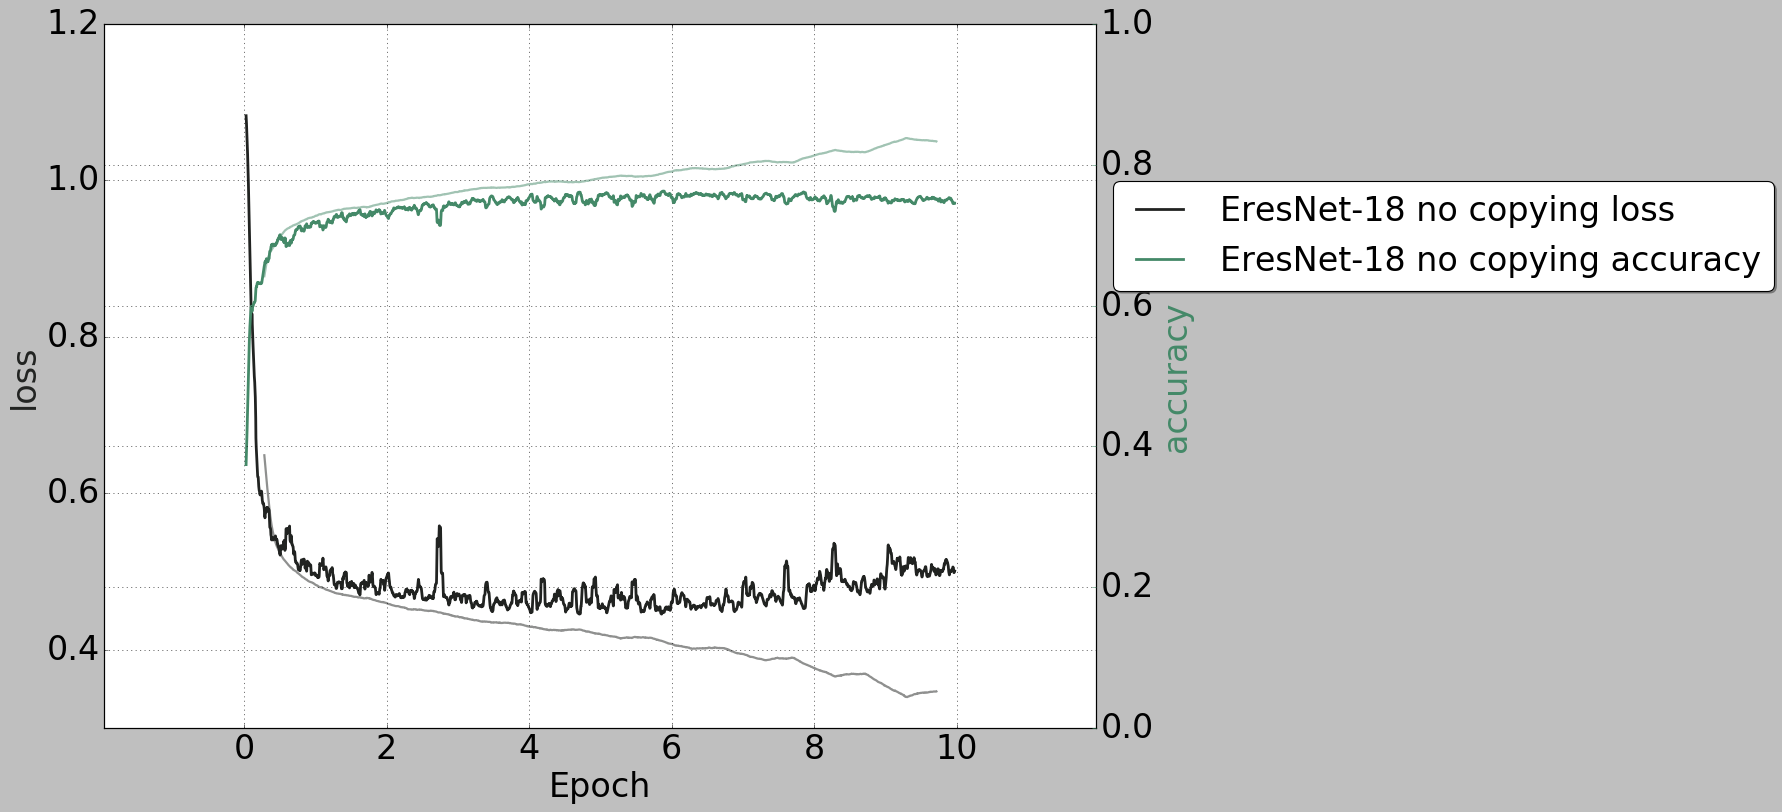

In [10]:
# EXAMPLE OF TRAINING PLOTS FOR MULTIPLE MODELS

dumps_path = "/home/ttuinstr/VAE/dumps/"
#run_ids = [["20191202_095740"], ["20191202_095803"]]
run_ids = [["20200117_162156"],["20200114_142948"],["20200131_001030"]]
#model_ids = [["EresNet-18"], ["EtworesNet-18"]]
model_ids = [["EresNet-152"],["EresNet-18 energy only"],["EresNet-18 no copying"]]

for run_id, model_id in zip(run_ids, model_ids):
    model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_id]
    keys = ["loss", "accuracy"]

    plot_log(run_id, model_id, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), val=True, log=False, show=True, mov_av=True)

One plot for all the training runs

Generic function to plot the ROC (Efficiency vs Background rejection)

Plot signal efficiency vs background rejection plots

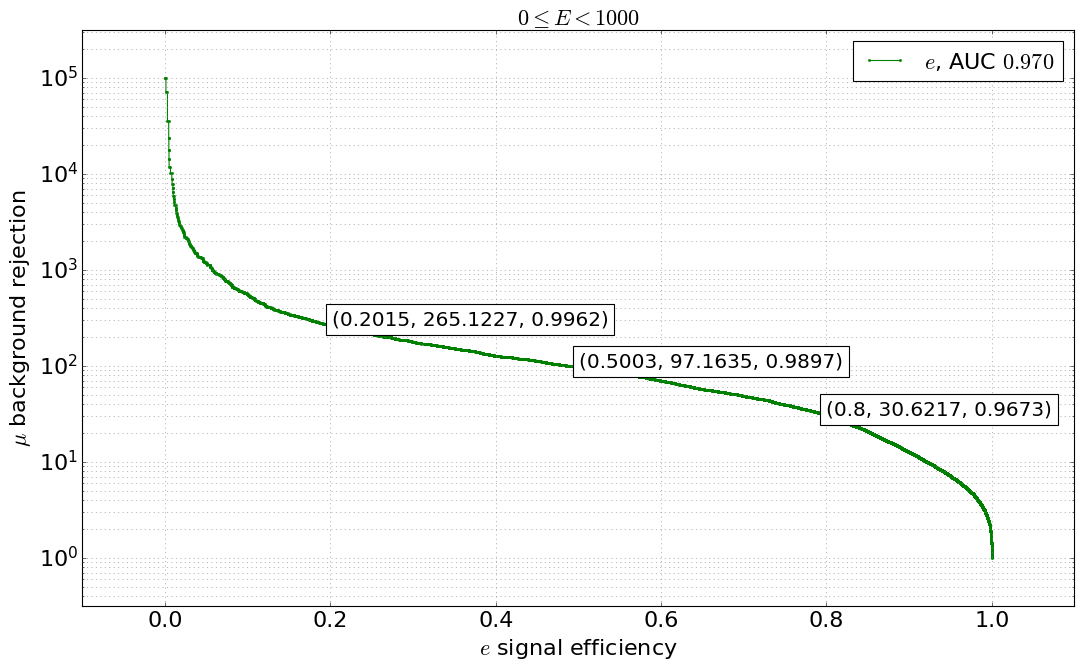

In [10]:
run_ids = ["20200417_092652"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "mu", min_energy=0,
                               max_energy=1000, show_plot=True)

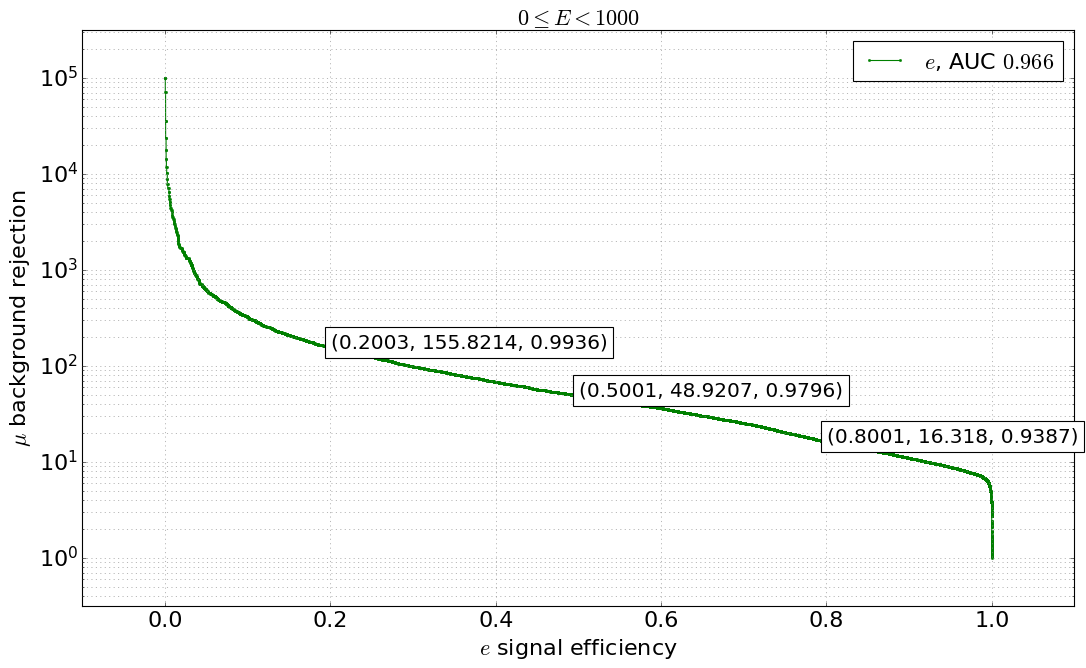

In [38]:
run_ids = ["20200117_172411"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/val_valid_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "mu", min_energy=0,
                               max_energy=1000, show_plot=True)

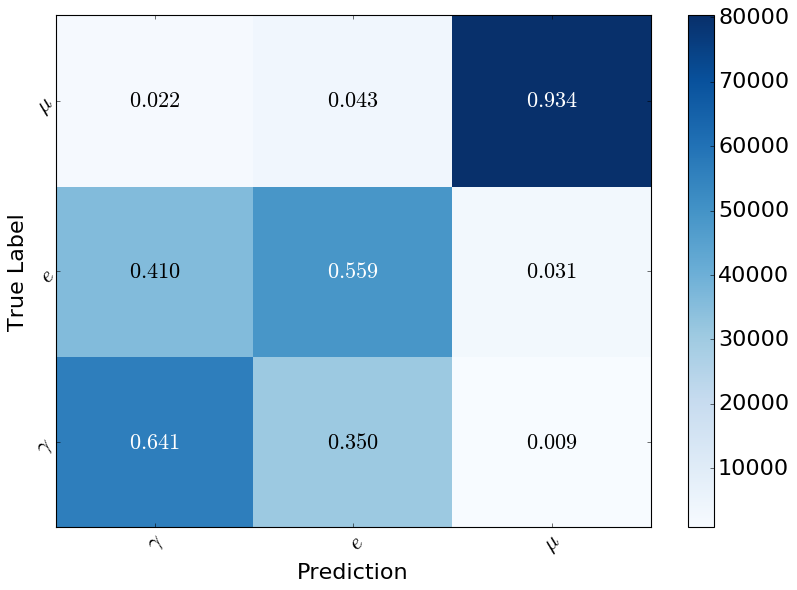

In [14]:
class_names = ['$\gamma$','$e$','$\mu$']

run_ids = ["20200117_172411"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/val_valid_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_predictions  = test_dump_np['predicted_labels'].flatten()
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    plot_confusion_matrix(test_labels, test_predictions, ['$\gamma$','$e$','$\mu$'])

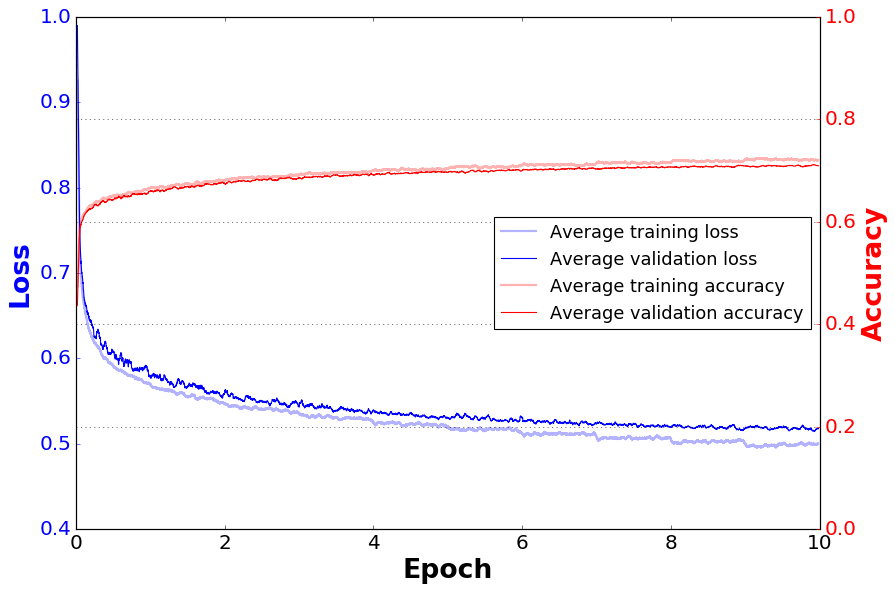

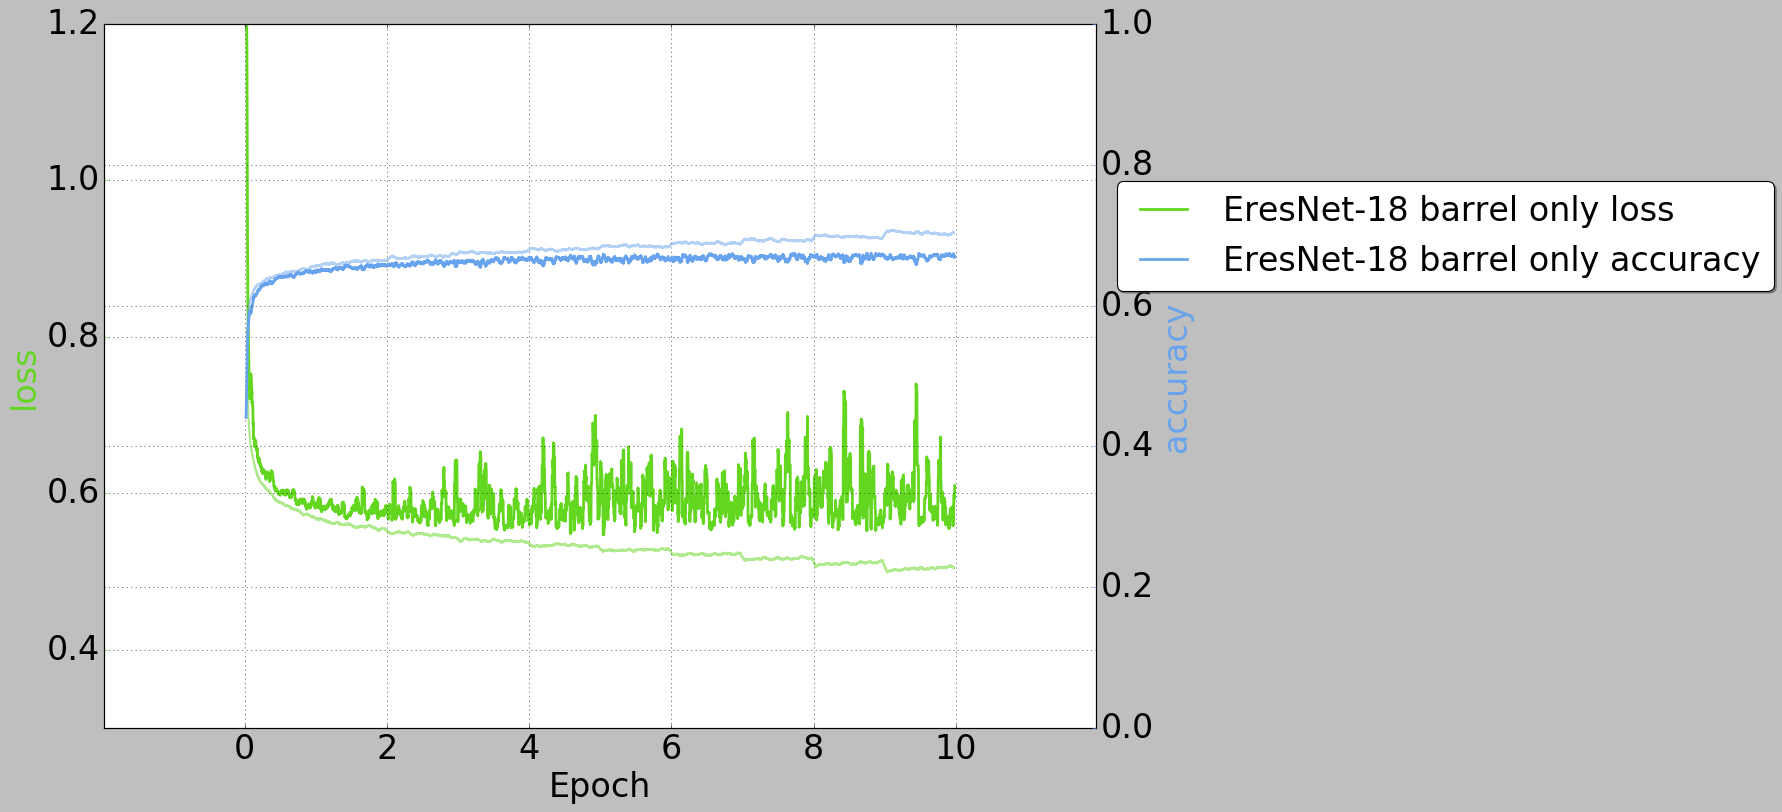

In [11]:
# EXAMPLE OF BOTH TYPES OF TRAINING PLOT FOR THE SAME MODEL

loc = "/home/ttuinstr/VAE/dumps/20200318_123343"
#disp_learn_hist_smoothed(loc,window_train=200,window_val=1)
disp_learn_hist_smoothed(loc)

dumps_path = "/home/ttuinstr/VAE/dumps/"
#run_ids = [["20191202_095740"], ["20191202_095803"]]
run_ids = [["20200110_170718"]]

#model_ids = [["EresNet-18"], ["EtworesNet-18"]]
model_ids = [["EresNet-18 barrel only"]]

for run_id, model_id in zip(run_ids, model_ids):
    model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_id]
    #model_colors = [([]) for model in model_id]
    keys = ["loss", "accuracy"]
    plot_log(run_id, model_id, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), val=True, log=False, show=True, mov_av=True)